In [ ]:
# Example of chaotic migration using dynamical tides operator
import rebound
import reboundx
from matplotlib import pyplot as plt
from reboundx import constants
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 14})

# intial conditions
a0 = 1.5
e0 = 0.01
R_star = 4.65e-3 # 1 solar radius
R_planet = 1.6 * 4.67e-4 # 1.6 Jupiter radii
m_planet = 0.95e-3 # approximately 1 Jupiter mass

# create simulation
sim = rebound.Simulation()
sim.add(m=1, r = R_star)
sim.add(m=m_planet, r=R_planet, a=a0, e=e0)
sim.add(m=1, a=50, inc=84.5 * np.pi / 180)
sim.move_to_com()

# load reboundx and the dynamical tides operator
rebx = reboundx.Extras(sim)
td = rebx.load_force('tides_dynamical')
rebx.add_force(td)


# load tides_constant_time_lag
time_lag = rebx.load_force("tides_constant_time_lag")
rebx.add_force(time_lag)
sim.particles[0].params['tctl_k2'] = 0.03
sim.particles[1].params['tctl_k2'] = 0.25
sim.particles[1].params['tctl_tau'] = 10 * 2*np.pi / (3600*24*365.25) # time lag of 10 second s

# load gr
gr = rebx.load_force("gr_full")
rebx.add_force(gr)
gr.params["c"] = constants.C

# set dP_crit = 0.01 to carry out mode evolution when in the chaotic regime
sim.particles[1].params['td_dP_crit'] = 1

# set initial modes to 0
sim.particles[1].params['td_c_imag'] = 0
sim.particles[1].params['td_c_real'] = 0

# record initial orbital energy
o = sim.particles[1].orbit(primary=sim.particles[0])
EB0 = -sim.G * sim.particles[1].m * sim.particles[0].m / (2 * o.a)

N = 10000
t = np.linspace(0, 2e5, N) # time
a = np.zeros(N) # semi-major axis
a2 = np.zeros(N) # semi-major axis of binary
e2 = np.zeros(N) # semi-major axis of binary
e = np.zeros(N) # eccentricity
E = np.zeros(N) # mode energy
E_sim = np.zeros(N) # simulation energy


#sim.heartbeat = heartbeat
for i, time in tqdm(enumerate(t), total=N):
    o = sim.particles[1].orbit(primary=sim.particles[0])
    a[i] = o.a
    e[i] = o.e
    E[i] = abs(EB0) * (sim.particles[1].params['td_c_imag']**2 + sim.particles[1].params['td_c_real']**2)
    E_sim[i] = sim.energy()

    o2 = sim.particles[2].orbit(primary=sim.particles[0])
    a2[i] = o2.a
    e2[i] = o2.e

    if i % 25 == 0 and i != 0:
        print(time, o.a, o.e, E[i])
    
    sim.integrate(2 * np.pi * time)
    



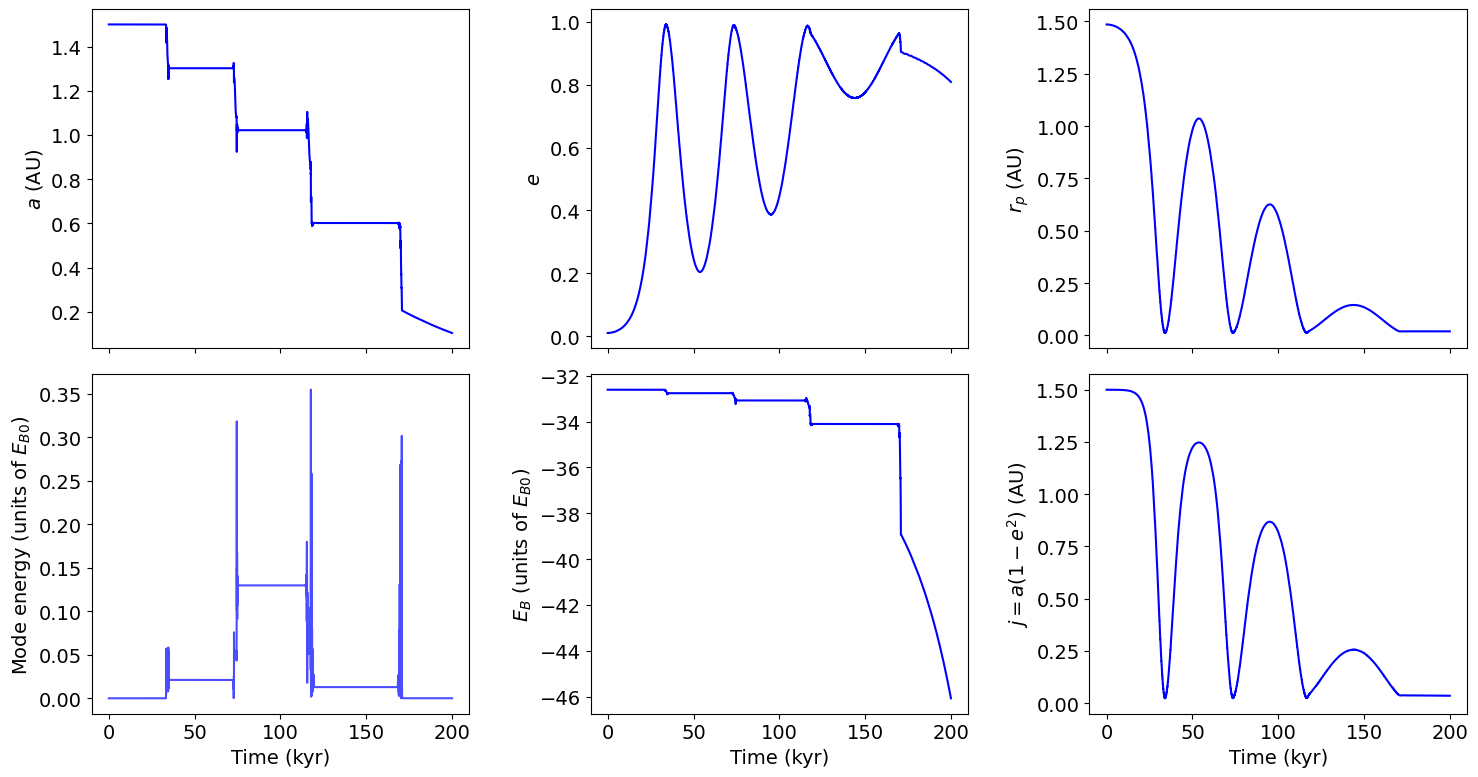

In [94]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(15)

axes[0, 0].plot(t / 1e3, a, c='blue')
axes[0, 0].set_ylabel(r'$a$ (AU)')

axes[0, 1].plot(t / 1e3, e, c='blue')
axes[0, 1].set_ylabel(r'$e$')

axes[1, 0].plot(t / 1e3, -E / EB0, alpha=0.7, c='blue')
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B0}$)')
axes[1, 0].set_xlabel(r'Time (kyr)')

axes[1, 1].plot(t / 1e3, -E_sim / EB0, c='blue')
axes[1, 1].set_ylabel(r'$E_B$ (units of $E_{B0}$)')
axes[1, 1].set_xlabel(r'Time (kyr)')

axes[0, 2].plot(t / 1e3, a * (1-e), c='blue')
axes[0, 2].set_ylabel(r'$r_p$ (AU)')

axes[1, 2].plot(t / 1e3, a * (1-e**2), c='blue')
axes[1, 2].set_ylabel(r'$j = a(1-e^2)$ (AU)')
axes[1, 2].set_xlabel(r'Time (kyr)')

plt.tight_layout()
